In [1]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
blobs, blob_labels = sk.datasets.make_blobs(n_samples=200, n_features=2, center_box=(0, 10.0), centers=2, random_state=1)
blobs = blobs.round(3)

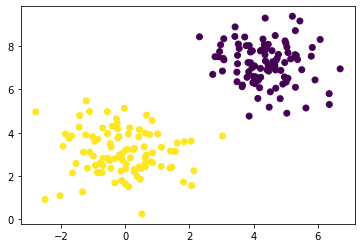

In [3]:
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels)

In [13]:
k = 2
D = 0.0005
eps = 0.1
X = blobs
alpha = 5 #take alpha as an arbitrary number - constant, lets say 5
n_initial = len(X) # n is the size of the current point set, a.k.a. n is all of the initial points
Opt = -int(- (alpha+1)*(np.log(np.sqrt(2)) / np.log(1 + eps)) // 1) #rounded up

In [49]:
def recursive_split(X, cell, k, D, eps, opt, n_initial, delta, nr_of_cells, cs, Z=[], c_centers=[], i=0):
    x1, x2, y1, y2 = cell
    points_in_cell = X[(X[:, 0] >= x1) & (X[:, 0] < x2) & (X[:, 1] >= y1) & (X[:, 1] < y2)]
    
    threshold = delta*(opt/pow(2, i))
    print("Threshold value: " + str(round(threshold, 5)))
    
    if len(points_in_cell) < threshold:
        # If there are less than the threshold number of points, it's a light cell
        # First time this is checked, it checks the grid g**1 if it is light (step #3)
        # Afterwards when it recurs it does step #3.4, marks c as a light cell and adds it to Z
        # Also when it recurs it does step #3.5 here (delete c from Y) as the light cell c will no longer be recured
        
        if len(points_in_cell) >= 1: 
            print("Points in light cell:\n " + str(points_in_cell))
            # If c is not empty (this already checks step #4)
            Z.append(points_in_cell)
            # Save the center coordinates for step #4.1
            c_centers.append(((x1 + x2) / 2, (y1 + y2) / 2))
    else: 
        print("Current number of cells: " + str(nr_of_cells))
        # Cell counter, each time a cell gets split into 4 subcells the total increases by 3
        nr_of_cells = nr_of_cells + 3

        # The would-be number of cells if the below code executes
        # Does not allow to create more subcells than cs
        if nr_of_cells <= cs: 
            # Step #3.1 if c is heavy then
            # Split the cell
            # First time this executes - only if g**1 is heavy and splits it into 4 sub-cells c1, c2, c3, c4 (step #3)
            # Afterwards the level of each cell goes to g**i, with side length 2**i with each recursion
            i = i + 1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            cells = [
                (x1, mid_x, y1, mid_y),  # Top-left
                (mid_x, x2, y1, mid_y),  # Top-right
                (x1, mid_x, mid_y, y2),  # Bottom-left
                (mid_x, x2, mid_y, y2)   # Bottom-right
            ]
            # Step #3.2 and #3.3 as it implicitly adds c1, c2, c3, c4 to Y with each recursion below
            for sub_cell in cells:
                recursive_split(points_in_cell, sub_cell, k, D, eps, opt, n_initial, delta, nr_of_cells, cs, Z, c_centers, i)

    return Z, c_centers

In [6]:
def coreset(Z, rep_c, delta, cs, eps):
    
    # rep_c = c_centers
    # Step #4.2: number of  points in each cell
    n_c = [len(c) for c in Z]
    
    # Conditional fail statement to return
    fail = False
    
    # Step #4.3: pair respective center coordinates with number of points in each cell
    S = [] #pairs
    for index in range(0, len(rep_c)):
        S.append([rep_c[index], n_c[index]])
    if len(S) > cs*(1+eps):
        fail = True
        return fail
    else:
        return S

In [47]:
def coreset_construction(X, k, D, eps, n_initial):
    
    if X.size > 0: 
        print("The array is non-empty, proceeding with coreset construction algorithm")
        
        # Step #0: empty arr to store light cells c
        Z = np.empty((1,2))
        
        # Step #1: Define the boundaries of the coordinate plane, at the start let Y be the only cell in grid g^(log(D))
        x_min, x_max, y_min, y_max = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
        Y = x_min, x_max, y_min, y_max
        
        # Calculate delta
        delta = ((1/(4*k*np.sqrt(D)) * np.log(n_initial+1))) * pow((eps/(14*np.sqrt(D))), D)
        print("delta = " + str(delta))
        # Calculate coreset size
        cs = 2/delta + np.log(n_initial+2)*k*pow(2, D)
        print("cs = " + str(cs))

        for j in range(0, Opt):
            print("\nIteration j = " + str(j) + ", where the passed Opt = (1+eps)^j = " + str(pow((1+eps), j)) + "\n")
            
            # Cell counter
            nr_of_cells = 1
            
            # Start the recursive splitting
            # Here Opt = (1+eps)^j
            Z, c_centers = recursive_split(X, Y, k, D, eps, pow((1+eps), j), n_initial, delta, nr_of_cells, cs)

            # Start the coreset calculation
            S = coreset(Z, c_centers, delta, cs, eps)

            if S != True:
                print("\n Coreset constructed: \n" + str(S))
                return S
        return "Coreset could not be constructed"
    else:
        return "The array is empty."

In [50]:
coreset_construction(X, k, D, eps, n_initial)

The array is non-empty, proceeding with coreset construction algorithm
delta = 29.629464433352798
cs = 10.687715819597356

Iteration j = 0, where the passed Opt = (1+eps)^j = 1.0

Threshold value: 29.62946
Current number of cells: 1
Threshold value: 14.81473
Current number of cells: 4
Threshold value: 7.40737
Current number of cells: 7
Threshold value: 3.70368
Points in light cell:
 [[-2.505  0.909]
 [-2.036  1.081]]
Threshold value: 3.70368
Points in light cell:
 [[-1.331  1.263]]
Threshold value: 3.70368
Points in light cell:
 [[-1.65   2.133]]
Threshold value: 3.70368
Current number of cells: 10
Threshold value: 7.40737
Current number of cells: 7
Threshold value: 3.70368
Points in light cell:
 [[0.516 0.241]]
Threshold value: 3.70368
Threshold value: 3.70368
Current number of cells: 10
Threshold value: 3.70368
Current number of cells: 10
Threshold value: 7.40737
Current number of cells: 7
Threshold value: 3.70368
Points in light cell:
 [[-1.942  3.376]]
Threshold value: 3.70368
Curr

'Coreset could not be constructed'

In [ ]:
# leftover code, for later use of visualising of splitting of coordinate plain

In [35]:
# def recursive_split(X, rectangle, threshold=3, result=[]):
#     x1, x2, y1, y2 = rectangle
#     points_in_rectangle = X[(X[:, 0] >= x1) & (X[:, 0] < x2) & (X[:, 1] >= y1) & (X[:, 1] < y2)]
    
#     if len(points_in_rectangle) < threshold:
#         # If there are less than the threshold number of points, it's a light rectangle
#         print(points_in_rectangle)
#         if len(points_in_rectangle) >= 1:
#             result.append(points_in_rectangle)
#     else:
#         # Split the rectangle
#         mid_x = (x1 + x2) / 2
#         mid_y = (y1 + y2) / 2
#         rectangles = [
#             (x1, mid_x, y1, mid_y),  # Top-left
#             (mid_x, x2, y1, mid_y),  # Top-right
#             (x1, mid_x, mid_y, y2),  # Bottom-left
#             (mid_x, x2, mid_y, y2)   # Bottom-right
#         ]

#         for sub_rect in rectangles:
#             recursive_split(points_in_rectangle, sub_rect, threshold, result)

#     return result

# # Define the boundaries of the coordinate plane
# x_min, x_max, y_min, y_max = min(blobs[:, 0]), max(blobs[:, 0]), min(blobs[:, 1]), max(blobs[:, 1])


# # Create a plot to visualize the coordinate plane
# plt.figure(figsize=(6, 6))
# plt.xlim(x_min - 1, x_max + 1)
# plt.ylim(y_min - 1, y_max + 1)

# # Start the recursive splitting
# result = recursive_split(X, (x_min, x_max, y_min, y_max))

# # Convert the result to a NumPy array
# result_array = np.array(result)

# # Plot the random points
# x, y = X.T
# plt.scatter(x, y, s=10, c='b', marker='o')



# # Print the result (points in each rectangle)
# print("Resulting Points in Each Rectangle:")
# for i, rect in enumerate(result):
#     print(f"Rectangle {i + 1}: {rect}")